In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
# import sys
# sys.path.append('C:\\Users\\Aengus Kennedy\\Documents\\GitHub\\ME0134-Aengus-Kennedy\\XRPLib')
# from XRPLib.encoder import Encoder

In [78]:
trial = 3 # can be 1, 2, 3

data_path = 'l3.{}data.csv'.format(trial)

with open(data_path, 'r') as f:
    data = f.readlines()

# Parse the data into lists
times = [] # in [ms]
left_positions = [] # in [encoder tics]
right_positions = [] # in [encoder tics]

for line in data:
    t, left, right = line.strip().split(',')
    times.append(float(t))
    left_positions.append(float(left))
    right_positions.append(float(right))

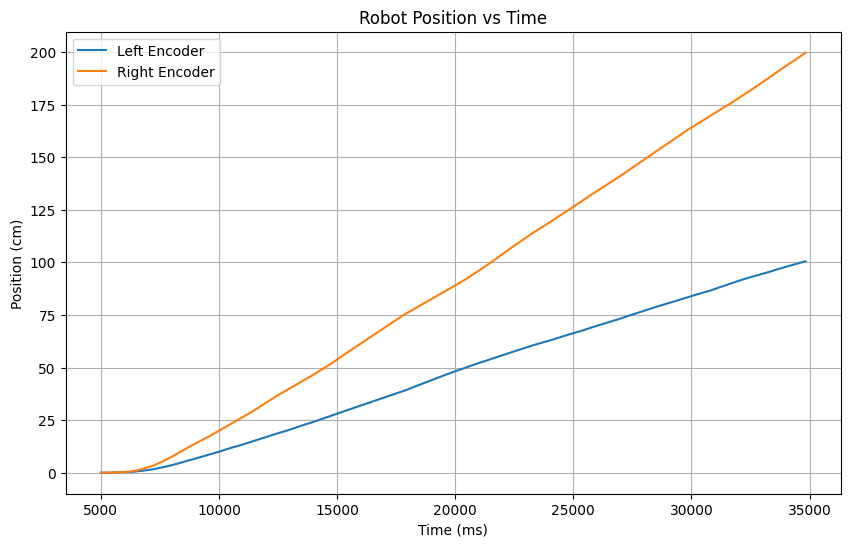

In [79]:
# display unintegrated encoder data over time

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(times, left_positions, label='Left Encoder')
plt.plot(times, right_positions, label='Right Encoder')
plt.xlabel('Time (ms)')
plt.ylabel('Position (cm)')
plt.title('Robot Position vs Time')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
# integrate left and right encoder data to get position and orientation

l = 6*2.54 # wheelbase diameter in [cm]

# encoder_resolution = 585 # in [counts/revolution], found in XRPLib.encoder.Encoder.resolution
# left_positions and right_positions are in [cm]

integrated_positions = [(0, 0, 0)] # in [cm, cm, rad]

# Loop through all data points
for i in range(1, len(left_positions)):
    # Get changes in left and right wheel positions
    delta_left = left_positions[i] - left_positions[i-1]  # cm
    delta_right = right_positions[i] - right_positions[i-1]  # cm

    # Calculate change in orientation (theta)
    delta_theta = (delta_right - delta_left) / l  # rad

    # Calculate distance traveled by center point
    delta_distance = (delta_right + delta_left) / 2  # cm

    # Calculate changes in x and y position
    # Use average theta during the step
    theta_avg = integrated_positions[-1][2] + delta_theta/2
    delta_x = delta_distance * math.cos(theta_avg)  # cm
    delta_y = delta_distance * math.sin(theta_avg)  # cm

    # Calculate new x, y, theta
    new_x = integrated_positions[-1][0] + delta_x
    new_y = integrated_positions[-1][1] + delta_y  
    new_theta = integrated_positions[-1][2] + delta_theta

    # Append the new position
    integrated_positions.append((new_x, new_y, new_theta))

# Print final position
print(f"Final position:")
print(f"x: {integrated_positions[-1][0]:.2f} cm")
print(f"y: {integrated_positions[-1][1]:.2f} cm")
print(f"θ: {math.degrees(integrated_positions[-1][2]):.2f} degrees")

Final position:
x: 0.39 cm
y: 9.06 cm
θ: 372.62 degrees


149
149
149
149
radius:  -10.000205526662072
149
149
14
i:  0
i:  14
i:  28
i:  42
i:  56
i:  70
i:  84
i:  98
i:  112
i:  126
i:  140


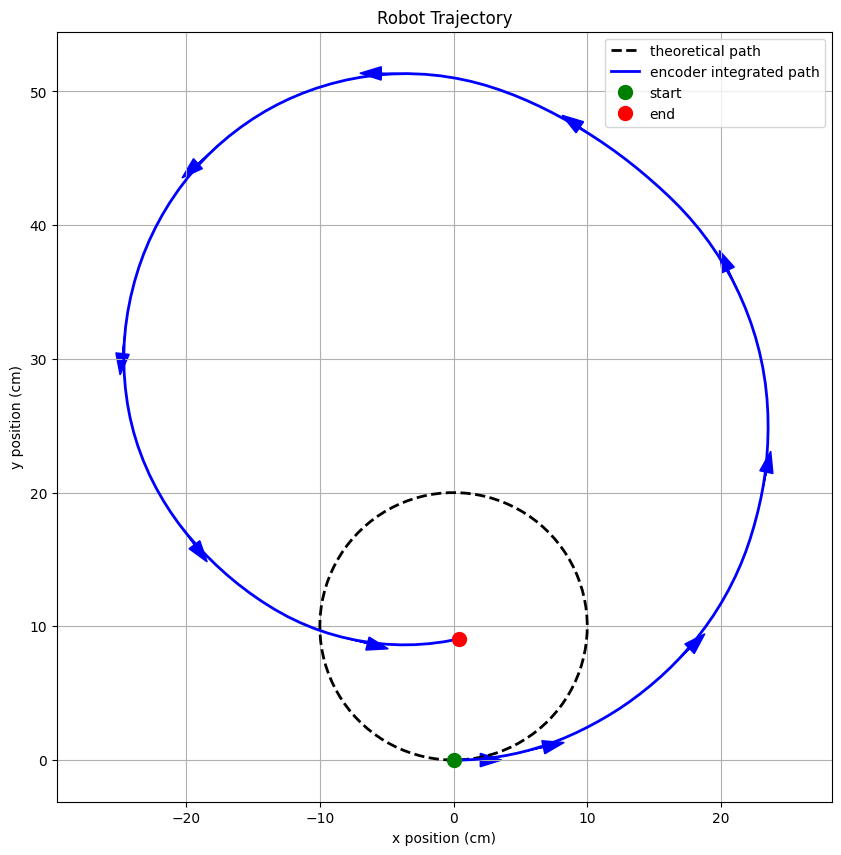

In [87]:
# Convert integrated_positions to numpy arrays for easier plotting
positions = np.array(integrated_positions)
x = positions[:, 0]
y = positions[:, 1]
theta = positions[:, 2]

print(len(positions))
print(len(x))
print(len(y))
print(len(theta))

# Create the plot
plt.figure(figsize=(10, 10))

# plot theoretical path
if trial == 1:
    theoretical_x = [0, 100]  # 0m, 1m, 2m in cm
    theoretical_y = [0, 0]      # Straight line at y=0
elif trial == 2:
    # Create straight line segment (50 cm forward)
    straight_x = np.linspace(0, 50, 50)
    straight_y = np.zeros_like(straight_x)
    
    # Create 1/4 circle arc
    radius = l/2 * (1 + 0.5 / 1 - 0.5)
    
    _theta = np.linspace(0, np.pi/2, 50)  # 1/4 circle = pi/2 radians
    arc_x = straight_x[-1] + radius + radius * np.sin(_theta)  # Start at x=50 where straight line ended
    arc_y = radius - radius * np.cos(_theta)
    
    # Combine the paths
    theoretical_x = np.concatenate([straight_x, arc_x])
    theoretical_y = np.concatenate([straight_y, arc_y])
elif trial == 3:
    l_r_ratio = 0.004985 / 0.036903
    l_speed = 0.5 / 0.875 / (340/360) # cm/s, determined to be about 30 sec/revolution
    r_speed = l_speed / l_r_ratio
    radius = l/2 * (l_speed + r_speed) / (l_speed - r_speed) * 2
    print('radius: ', radius)
    # Create full circle arc
    _theta = np.linspace(0, 2*np.pi, 100)  # Full circle = 2pi radians
    theoretical_x = radius * np.sin(_theta)  # Circle centered at (0,0)
    theoretical_y = - radius + radius * np.cos(_theta)

plt.plot(theoretical_x, theoretical_y, 'k--', label='theoretical path', linewidth=2)

# plot encoder integrated path
plt.plot(x, y, 'b-', label='encoder integrated path', linewidth=2)

# Add orientation arrows at regular intervals
print(len(x))
print(len(theta))
arrow_interval = len(x) // 10  # Show 10 arrows along the path
print(arrow_interval)
for i in range(0, len(x), arrow_interval):
    print('i: ', i)
    # Calculate arrow direction
    dx = 2 * np.cos(theta[i])  # 2cm length arrows
    dy = 2 * np.sin(theta[i])
    plt.arrow(x[i], y[i], dx, dy, 
             head_width=0.5*2, head_length=0.8*2, fc='b', ec='b')

# Add theoretical path here

# Add start and end markers
plt.plot(x[0], y[0], 'go', label='start', markersize=10)
plt.plot(x[-1], y[-1], 'ro', label='end', markersize=10)

# Customize the plot
plt.grid(True)
plt.axis('equal')  # Equal aspect ratio
plt.xlabel('x position (cm)')
plt.ylabel('y position (cm)')
plt.title('Robot Trajectory')
plt.legend()

# Show the plot
plt.show()